# Load Data

In [ ]:
# # '''
# # Unzip dataset
# # '''
# import zipfile
# zip_path = '/content/drive/MyDrive/dog emotion/archive.zip'
# target_directory = '/content/drive/MyDrive/dog emotion/'

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(target_directory)


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from PIL import Image
from torch import optim

from tqdm import tqdm

import numpy as np
import cv2
import csv
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet means and stds
])

dataset_path = '/content/drive/MyDrive/images/'


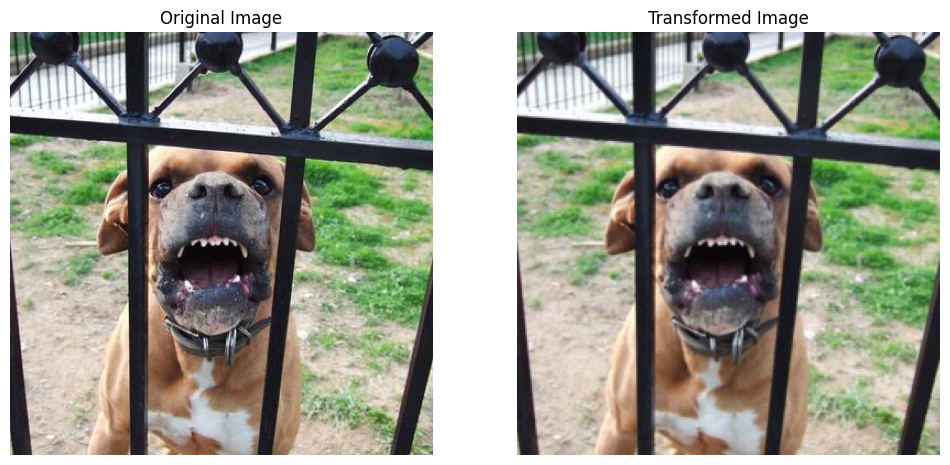

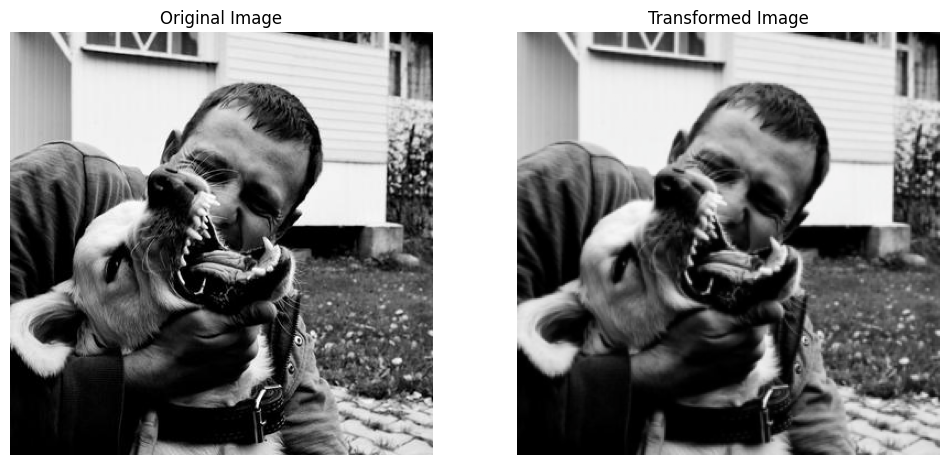

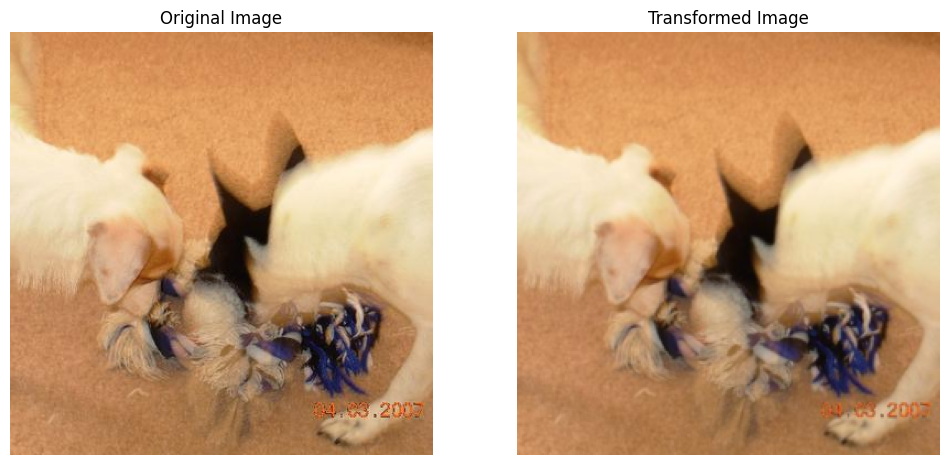

In [ ]:
dataset_no_transform = datasets.ImageFolder(root=dataset_path)

# Function to unnormalize for visualization
def unnormalize(image):
    for i in range(3):
        image[i] = image[i] * torch.tensor(std[i]) + torch.tensor(mean[i])
    return image

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Display 3 examples
for i in range(3):
    # Original image
    img_path, _ = dataset_no_transform.imgs[i]
    original_image = Image.open(img_path)

    # Transformed image
    transformed_image = transform(original_image)
    transformed_image = unnormalize(transformed_image)  # Unnormalize to display properly

    plt.figure(figsize=(12, 6))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    # Plot transformed image
    plt.subplot(1, 2, 2)
    plt.imshow(transformed_image.permute(1, 2, 0))  # Rearrange the tensor dimensions for displaying
    plt.title("Transformed Image")
    plt.axis('off')

    plt.show()

In [ ]:
dataset = datasets.ImageFolder(root='/content/drive/MyDrive/images/', transform=transform)

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# DNN Model Structure

In [ ]:
class DNN(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.fc1 = torch.nn.Linear(196608, 1024)
    self.fc2 = torch.nn.Linear(1024, 512)
    self.fc3 = torch.nn.Linear(512, 256)
    self.fc4 = torch.nn.Linear(256, 128)
    self.fc5 = torch.nn.Linear(128, 64)
    self.fc6 = torch.nn.Linear(64, 32)
    self.fc7 = torch.nn.Linear(32, 4)


  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = x.view(x.size(0), -1)  # Flatten x while keeping the batch size the same

    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.relu(x)
    x = self.fc4(x)
    x = F.relu(x)
    x = self.fc5(x)
    x = F.relu(x)
    x = self.fc6(x)
    x = F.relu(x)
    x = self.fc7(x)

    return x

# Training Utility Functions

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    total_train_loss = 0
    total_train_accuracy = 0

    progress_bar = tqdm(train_loader, desc=f'Training Epoch {epoch}', leave=False)

    for data, target in progress_bar:
        data, target = data.to(device), target.to(device)  # Move data and target to the correct device

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        acc = accuracy(output, target)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_accuracy += acc.item()

    average_train_loss = total_train_loss / len(train_loader)
    average_train_accuracy = total_train_accuracy / len(train_loader)

    return average_train_loss, average_train_accuracy

In [ ]:
def validate(model, val_loader, criterion, device):
    model.eval()
    total_val_loss = 0
    total_val_accuracy = 0
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc='Validating', leave=False)
        for data, target in progress_bar:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            acc = accuracy(output, target)

            total_val_loss += loss.item()
            total_val_accuracy += acc.item()

    average_val_loss = total_val_loss / len(val_loader)
    average_val_accuracy = total_val_accuracy / len(val_loader)

    return average_val_loss, average_val_accuracy


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    for epoch in range(num_epochs):
        avg_train_loss, avg_train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
        avg_val_loss, avg_val_acc = validate(model, val_loader, criterion, device)

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(avg_val_acc)

        print(f"Epoch: {epoch+1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_acc:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}")
    return history

In [ ]:
def plot_losses(history):
    losses = history['val_loss']
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    accuracies = history['val_acc']
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

# Experiment

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
model = DNN()
model.to(device)

DNN(
  (fc1): Linear(in_features=196608, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=32, bias=True)
  (fc7): Linear(in_features=32, out_features=4, bias=True)
)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)

Training Epoch 0:   0%|          | 0/398 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1, Training Loss: 1.3765, Training Accuracy: 0.3084, Validation Loss: 1.3502, Validation Accuracy: 0.3226


Epoch: 2, Training Loss: 1.3474, Training Accuracy: 0.3326, Validation Loss: 1.3492, Validation Accuracy: 0.3274


Epoch: 3, Training Loss: 1.3321, Training Accuracy: 0.3514, Validation Loss: 1.3460, Validation Accuracy: 0.3067


Epoch: 4, Training Loss: 1.3214, Training Accuracy: 0.3595, Validation Loss: 1.3431, Validation Accuracy: 0.3192


Epoch: 5, Training Loss: 1.3135, Training Accuracy: 0.3663, Validation Loss: 1.3396, Validation Accuracy: 0.3370


Epoch: 6, Training Loss: 1.3003, Training Accuracy: 0.3768, Validation Loss: 1.3570, Validation Accuracy: 0.3380


Epoch: 7, Training Loss: 1.2845, Training Accuracy: 0.3876, Validation Loss: 1.3495, Validation Accuracy: 0.3301


Epoch: 8, Training Loss: 1.2618, Training Accuracy: 0.3967, Validation Loss: 1.3905, Validation Accuracy: 0.3347


Epoch: 9, Training Loss: 1.2449, Training Accuracy: 0.4127, Validation Loss: 1.3851, Validation Accuracy: 0.3442


Epoch: 10, Training Loss: 1.2035, Training Accuracy: 0.4304, Validation Loss: 1.4329, Validation Accuracy: 0.3386


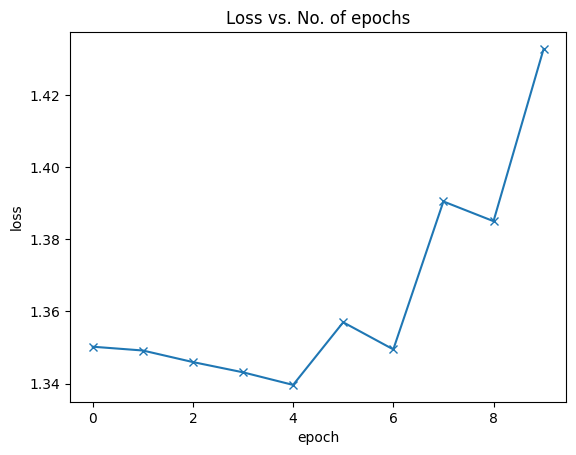

In [ ]:
plot_losses(history)

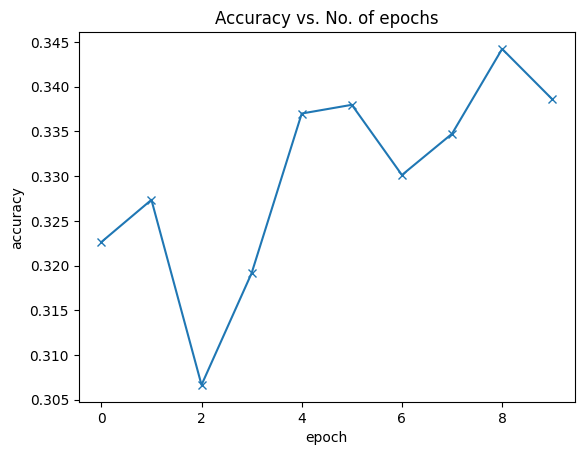

In [ ]:
plot_accuracies(history)